In [1]:
%load_ext autoreload
%autoreload 2
from DeepQLearning_env import *
from utils import *

### Question 11

In [2]:
trainer = DeepQTraining()
trainer.train(lambda e: 0.1, 0.5, self_training=False)

  0%|                                                                                                                                                                                               | 0/20000 [00:00<?, ?it/s]/Users/alessio/Document/EPFL/MA2/ANN/ANN2022_TicTacToe/utils.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor([grid==env.player2value[player.player], grid==env.player2value[get_other_player(player.player)]],dtype=torch.float).unsqueeze(0)
/Users/alessio/opt/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite o

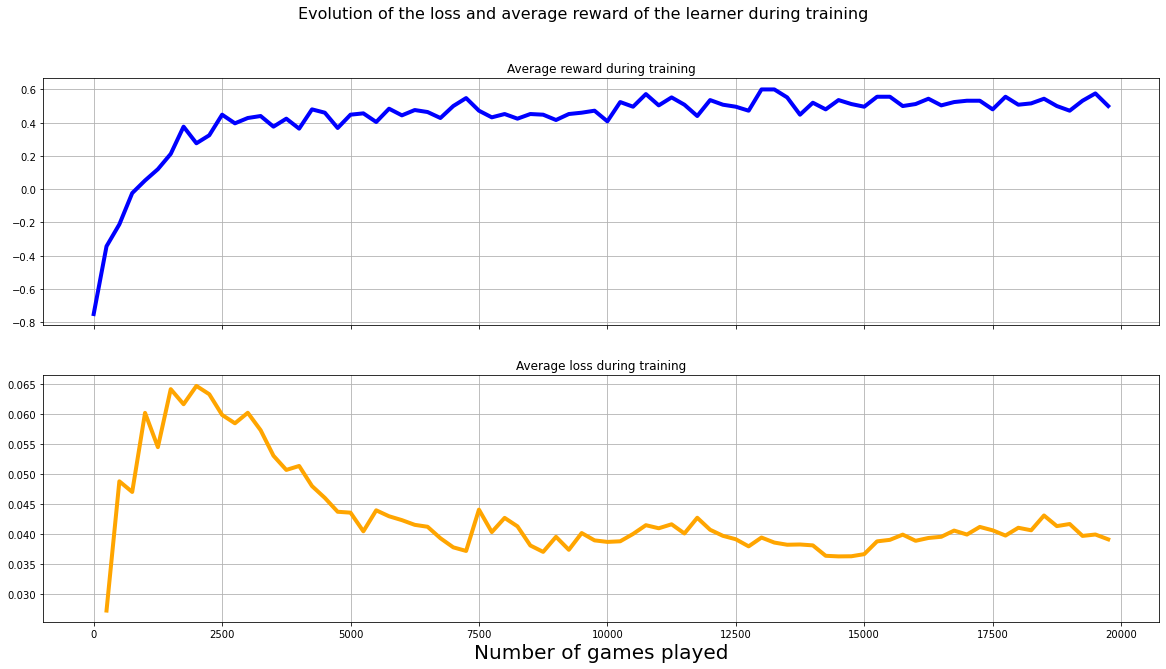

In [3]:
trainer.plot_avg_reward_loss_during_training()

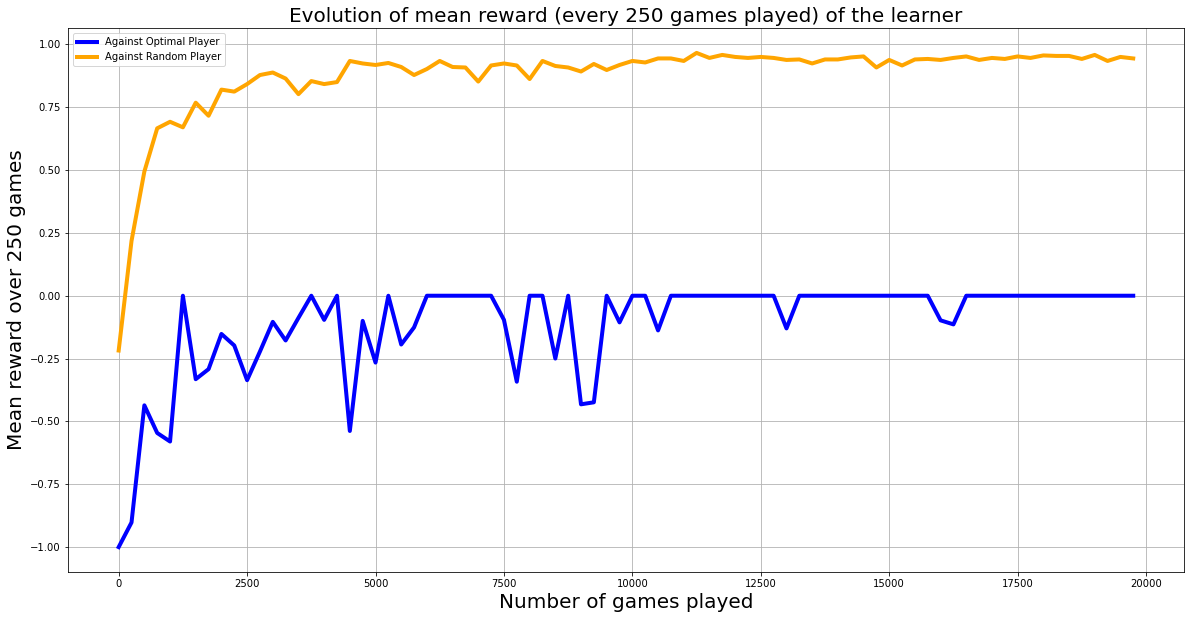

In [4]:
trainer.plot_mopt_mrng_during_training()

### Question 12

In [5]:
trainer12 = DeepQTraining(buffer_size=1, batch_size=1)
trainer12.train(lambda e: 0.1, 0.5, self_training=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:57<00:00, 55.98it/s]


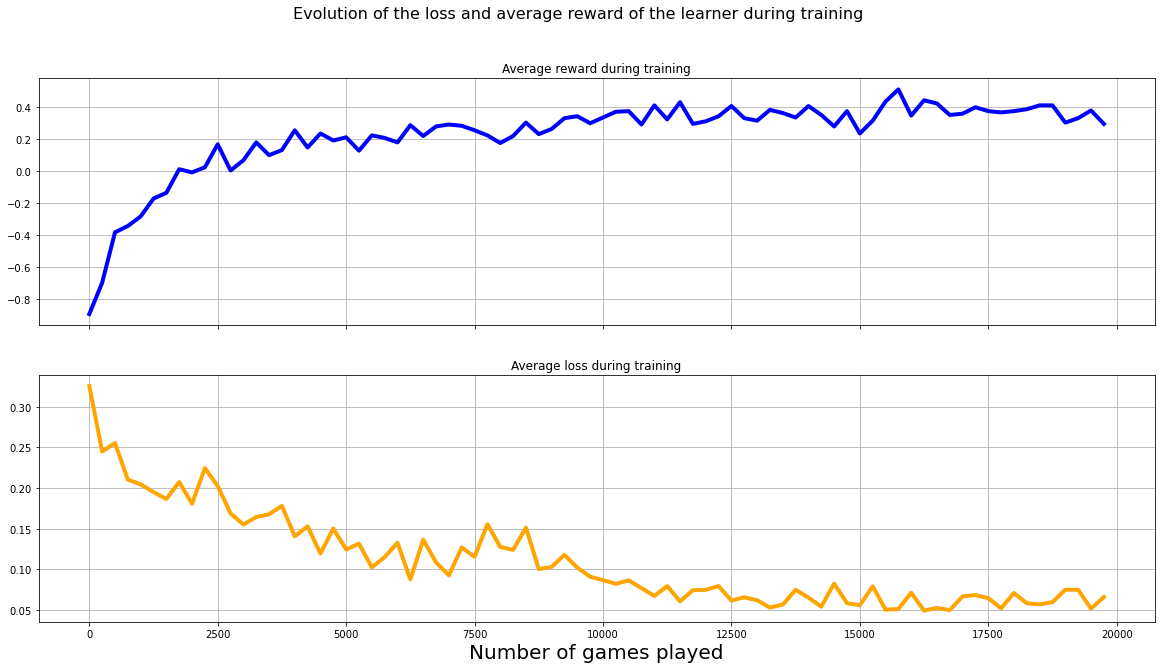

In [6]:
trainer12.plot_avg_reward_loss_during_training()

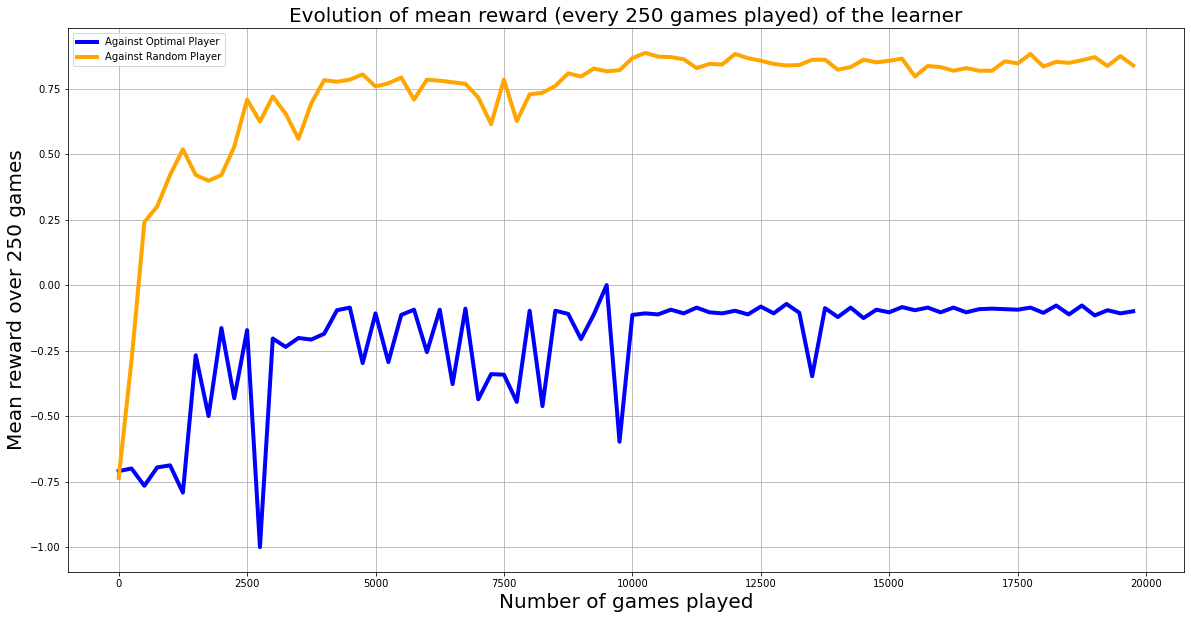

In [7]:
trainer12.plot_mopt_mrng_during_training()

### Question 13

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:01<00:00, 55.26it/s]


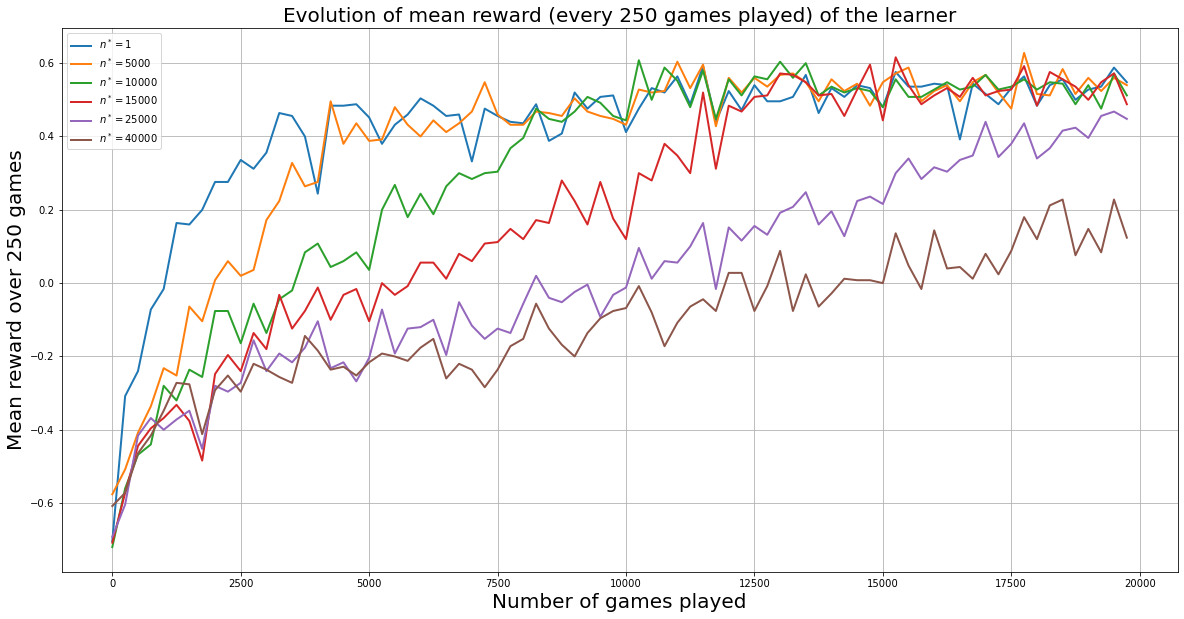

In [8]:
n_stars = [1, 5000, 10000, 15000, 25000, 40000]
epsilon_min = 0.1
epsilon_max = 0.8

values13 = []
values_mopt_mrng13 = []
names13 = []
epochs = 0
avg_step = 0

for n_star in n_stars:
    epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star))
    training13 = DeepQTraining()
    training13.train(epsilon_greedy_policy, 0.5, self_training=False)
    epochs = training13.epoch
    avg_step = training13.AVG_STEP
    
    values13.append(training13.avg_reward)
    values_mopt_mrng13.append([training13.score_test_opt, training13.score_test_rng])
    names13.append(f"$n^*=${n_star}")
    
plots_several_trainings(values13, names13, avg_step, epochs)

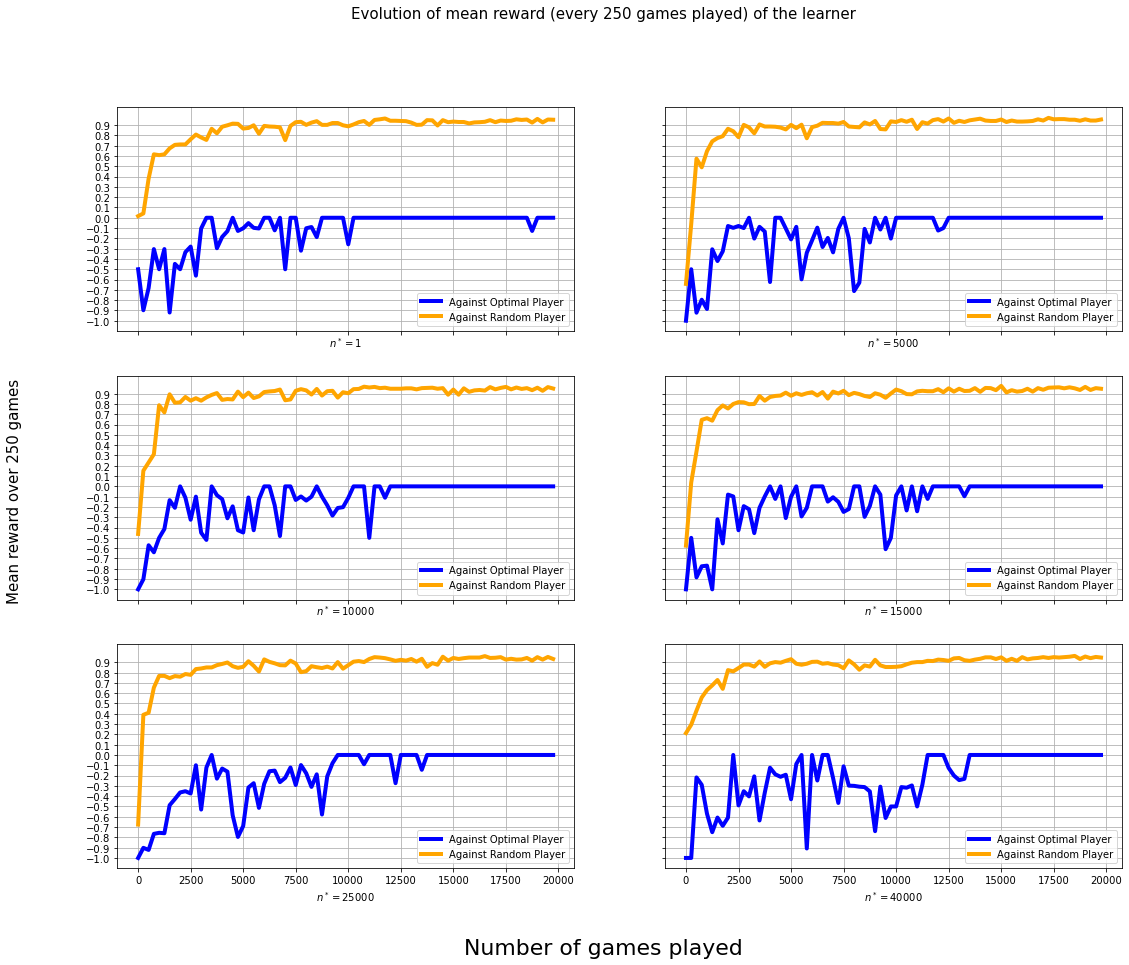

In [9]:
plots_several_trainings_subfigures(values_mopt_mrng13, names13, training13.TEST_STEP, epochs, mopt_mrng=True)

In [11]:
(max_Mrnd, max_Mopt), (best_eps_rnd, best_eps_opt) = get_max_Mopt_Mrng_for_epsilon(values_mopt_mrng13, n_stars, "n-star")

Maximal M_opt = 0.0 and is achieved for n-star = 1
Maximal M_rnd = 0.964 and is achieved for n-star = 10000


### Question 14

In [10]:
# Part 2.1.2

n_star_best = 10000

epsilon_opts = [0.0, 0.1, 0.3, 0.5, 0.8, 1.0]
epsilon_min = 0.1
epsilon_max = 0.8
epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star_best))

values14 = []
values_mopt_mrng14 = []
names14 = []
epochs = 0
avg_step = 0

for epsilon_opt in epsilon_opts:
    training14 = DeepQTraining()
    training14.train(epsilon_greedy_policy, epsilon_opt, self_training=False)
    epochs = training14.epoch
    avg_step = training14.AVG_STEP
    
    values14.append(training14.avg_reward)
    values_mopt_mrng14.append([training14.score_test_opt, training14.score_test_rng])
    names14.append(f"epsilon_opt={epsilon_opt}")
    
plots_several_trainings(values14, names14, avg_step, epochs)

 50%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 9999/20000 [03:37<03:37, 45.93it/s]


KeyboardInterrupt: 

In [ ]:
plots_several_trainings_subfigures(values14, names14, avg_step, epochs)

In [ ]:
plots_several_trainings_subfigures(values_mopt_mrng14, names14, training14.TEST_STEP, epochs, mopt_mrng=True)

### Question 15

In [ ]:
(max_Mrnd, max_Mopt), (best_eps_rnd, best_eps_opt) = get_max_Mopt_Mrng_for_epsilon(values_mopt_mrng14,epsilon_opts, "epsilon-opt")

## Self Learning
### Question 16

In [ ]:
# Part 2.1.2
epsilon_opts = [0.0, 0.1, 0.3, 0.5, 0.8, 1.0]

values16 = []
values_mopt_mrng16 = []
names16 = []
epochs = 0
avg_step = 0

for epsilon_opt in epsilon_opts:
    training16 = DeepQTraining()
    training16.train(lambda ep: epsilon_opt, epsilon_opt, self_training=True)
    epochs = training16.epoch
    avg_step = training16.AVG_STEP
    
    values16.append(training16.avg_reward)
    values_mopt_mrng16.append([training16.score_test_opt, training16.score_test_rng])
    names16.append(f"epsilon_opt={epsilon_opt}")
    
plots_several_trainings(values16, names16, avg_step, epochs)

In [ ]:
plots_several_trainings_subfigures(values_mopt_mrng16, names16, training16.test_step, epochs, mopt_mrng=True)

### Question 17

In [ ]:
n_stars = [1, 5000, 10000, 15000, 25000, 40000]
epsilon_min = 0.1
epsilon_max = 0.8

values17 = []
values_mopt_mrng17 = []
names17 = []
epochs = 0
avg_step = 0

for n_star in n_stars:
    epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star))
    training17 = DeepQTraining()
    training17.train(epsilon_greedy_policy, 0.5, self_training=True)
    epochs = training17.epoch
    avg_step = training17.avg_step
    
    values17.append(training17.avg_reward)
    values_mopt_mrng17.append([training17.score_test_opt, training17.score_test_rng])
    names17.append(f"$n^*=${n_star}")
    
plots_several_trainings(values17, names17, avg_step, epochs)

In [ ]:
plots_several_trainings_subfigures(values_mopt_mrng17, names17, training17.test_step, epochs, mopt_mrng=True)training2

### Quetion 18

In [ ]:
(max_Mrnd, max_Mopt), (best_eps_rnd, best_eps_opt) = get_max_Mopt_Mrng_for_epsilon(values_mopt_mrng17, n_stars, "n_star")

### Question 19

In [ ]:
# Same position as in Q-learning

states = ["---------", "XX-OO----", "X--O-X-O-"]
titles = ["Starting board", "Winning position", "Tactical move"]

# situation1: Starting board
"""
- - -
- - -
- - -
"""
# situation2: Winning position
""" 
X X -
O O -
- - -
"""

# situation3: Tactical move
""" 
X - -
O - X
- O -
"""

# Train the self-learners to obtain final Q-values
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 10000 # TODO change to the best n_start
training_heat = DeepQTraining()
training_heat.train(lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star)), 0.5, run_test=False, self_training=True)

In [ ]:
grids = [
    np.zeros((3,3)),
    np.array([[1,1,0],[-1,-1,0],[0,0,0]]),
    np.array([[1,0,0],[-1,0,1],[0,-1,0]]),
]

plot_game_heatmaps_deep_qlearning(states, training_heat.agent1,grids,["X","O","X"], titles)

## Comparison Q-Learning vs DeepQ-Learning

### Question 20

In [ ]:
from QLearning_env import QPlayer, QTraining, get_state_best_Q

In [ ]:
n_star_best = 15000
epsilon_min = 0.1
epsilon_max = 0.8
epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star_best))
epsilon_opt = 0.0

training_q_opt = QTraining(epsilon_greedy_policy)
training_q_opt.train(epsilon_opt, run_test=True)

In [ ]:
n_star_best = 15000
epsilon_min = 0.1
epsilon_max = 0.8
epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star_best))
epsilon_opt = 0.0

training_q_self = QTraining(epsilon_greedy_policy)
training_q_self.train(epsilon_opt, run_test=True, self_learning=True)

In [ ]:
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 10000 # TODO change to the best n_start
training_deep_q_opt = DeepQTraining()
training_deep_q_opt.train(lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star)), 0.0, run_test=True, self_training=False)

In [ ]:
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 10000 # TODO change to the best n_start
training_deep_q_self = DeepQTraining()
training_deep_q_self.train(lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star)), 0.5, run_test=True, self_training=True)

In [ ]:
get_performance_table(training_q_opt,training_deep_q_opt,training_q_self,training_deep_q_self)